# Building Footprints - OSM AND Microsoft

Notebook to download buildings data from osm open data and Microsoft Building Footprints. These are both open data sets to download building data that have varying degrees of accuracy across geographic regions.  We also downloaded Open Africa buildings from Google, however, we used the website's GUI to download instead of programatically:  
- https://sites.research.google/open-buildings/#download

We have also created osm queries through overpass to gather the asset types relevant to the World Bank. 

- This query returns [objects relevant to the World Bank](https://overpass-turbo.eu/s/1tN7) which unfortunately doesn't return many shapes for our AOI. 

- We can illustrate this query in [New York](https://overpass-turbo.eu/s/1tN8) where objects are returned. This may be due to more active OSM contributors in North America and speaks to volunteered geographic information systems inconsistent quality. 

- To gather [landuse](https://overpass-turbo.eu/s/1tNf) from our AOI.


In [15]:
import osmnx as ox
import geopandas as gpd
import pystac_client
from pystac_client import Client
import planetary_computer
import os
import geojson
import numpy as np
import geopandas
import matplotlib.pyplot as plt
%matplotlib inline
from shapely import geometry

For our area in Beitbridge we can query OSM from a bbox and through a place name query. 

In [7]:
place_bbox = [-22.148,-22.254,30.054,29.938]

In [8]:
place_name = "Zimbabwe"

Additionally, we can save the Save AOI as a geojson for future use. `lon_lat_list` is hard coded here.

In [9]:
lon_lat_list = [[29.938,-22.254],[29.938,-22.148],[30.054,-22.148],[30.054,-22.254],[29.938,-22.254]]
polygon_geom = geometry.Polygon(lon_lat_list)
polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon_geom])       
polygon.to_file(filename='AOI_polygon.geojson', driver='GeoJSON')

# OSM Buildings

Create a graph from OSM using `place_bbox` for Beitbridge.

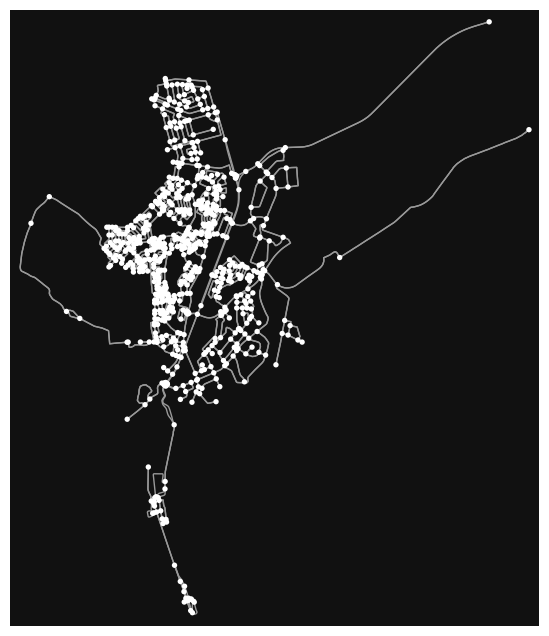

In [10]:
G = ox.graph_from_bbox(place_bbox[0],place_bbox[1],place_bbox[2],place_bbox[3], network_type='drive', simplify=True, retain_all=False)
fig, ax = ox.plot_graph(G)

Get the building footprints from a bbox and plot them. 

(29.938105, 30.0540557, -22.2513996, -22.1488729)

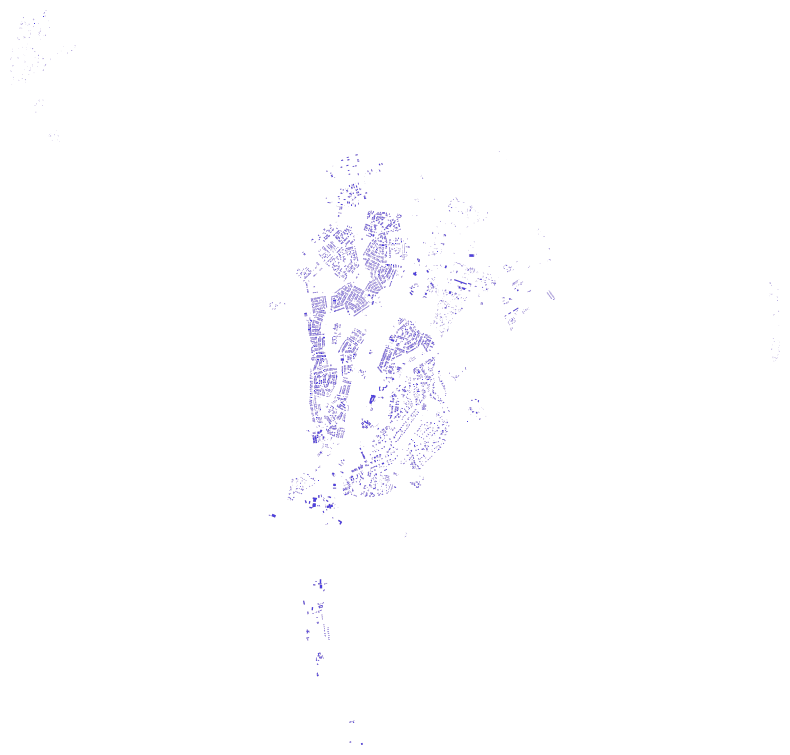

In [5]:
#plot building footprint
buildings = ox.geometries_from_bbox(place_bbox[0],place_bbox[1],place_bbox[2],place_bbox[3],tags={'building': True})
fig, ax = ox.plot_footprints(buildings, alpha=0.4, show=False)
buildings.plot(ax=ax, facecolor="blue", alpha=0.7, zorder=2)
plt.tight_layout()
plt.axis("off")

# MS Buildings

Search against the Planetary Computer STAC API. You may need to register for an API key from planetary computer to make the following run:

In [11]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/",
    modifier=planetary_computer.sign_inplace,
)

Define your search with CQL2 syntax

In [12]:
search = catalog.search(filter_lang="cql2-json", filter={
  "op": "and",
  "args": [
    {"op": "=", "args": [{"property": "collection"}, "ms-buildings"]},
    {"op": "=", "args": [{"property": "msbuildings:region"}, place_name]},
    {
     "op": ">=",
     "args": [ { "property": "end_datetime" }, { "timestamp": "2018-11-20T00:00:00+00:00" } ]
    }
  ]
})


Grab the item from the search results

In [13]:
item = next(search.get_items())
print(item)
print(item.assets)
asset = item.assets["data"]


<Item id=Zimbabwe_2022-07-06>
{'data': <Asset href=abfs://footprints/global/2022-07-06/ml-buildings.parquet/RegionName=Zimbabwe>}


Convert data into geopandas

In [14]:
df = geopandas.read_parquet(
    asset.href,
    storage_options=asset.extra_fields["table:storage_options"],
)
df=df.drop(columns="quadkey")
gdf=geopandas.GeoDataFrame(df, crs="EPSG:4326")
print(df.head())

ImportError: Install adlfs to access Azure Datalake Gen2 and Azure Blob Storage

In [11]:
# Clip the data using GeoPandas clip
MS_clip = gpd.clip(gdf, polygon)

In [12]:
MS_Buildings=geopandas.GeoDataFrame(MS_clip, crs="EPSG:4326")
MS_Buildings.head()
MS_Buildings.to_file(filename="ms_buildings.geojson", driver='GeoJSON')

In [13]:
OSM_Buildings=geopandas.GeoDataFrame(buildings, crs="EPSG:4326")

In [14]:
OSM_Buildings.head()
OSM_Buildings1 = OSM_Buildings[['geometry','building','nodes']]
#OSM_Buildings.drop(columns=['osmid', 'layer', 'amenity', 'brand', 'name', 'shop',  'brand', 'roof:shape', 'ways', 'type'])

In [15]:
with open("./OSM_Buildings.geo.json",mode="w") as f:
  geojson.dump(OSM_Buildings,f)